In [1]:
import os
import re
import json
import subprocess
import matplotlib.pyplot as plt

from Bio import Entrez
from Bio import SeqIO
from Bio import Phylo
from Bio.Align.Applications import MuscleCommandline
from Bio.Phylo.Applications import PhymlCommandline

Entrez.email = "katerina.koptelova@yandex.ru"

## Определяем интересующие нас штаммы

Перечисляем названия организмов и штаммы, для которых хотим строить дерево (штамм можно не указывать)

In [2]:
# Археи
organisms = [ # (organism, strain)
    ('Archaeoglobus fulgidus', 'VC-16'),
    ('Ignicoccus hospitalis', 'KIN4/I'),
    ('Methanocaldococcus jannaschii', 'JCM 10045'),
    ('Methanococcus maripaludis', 'JJ'),
    ('Decoy', 'junk'),    # Такого в базах точно нет, скрипт отработает с предупреждением
    ('Pyrobaculum aerophilum', 'IM2'),
    ('Pyrobaculum calidifontis', 'VA1'),
    ('Pyrococcus horikoshii', 'JA-1'),
    ('Sulfolobus tokodaii', '7'),
]

# Бактерии
outgroup = [
    ('Desulfovibrio piger', 'ATCC 29098'),
    ('Herpetosiphon aurantiacus', ''),
    ('Rhodopirellula baltica', 'SH 1'),
]

## Получение данных из RefSeq

In [3]:
# 16S RefSeq Nucleotide sequence records
# https://www.ncbi.nlm.nih.gov/refseq/targetedloci/16S_process/
REFSEQ_16S_RNA_TERM = '33175[BioProject] OR 33317[BioProject]'    # Курируемая база 16S РНК бактерий и архей (очень хорошая)

# Задаем имена файлов
RAW_SEQ_FILENAME = '16S_sequences.fasta'    # файл с сырыми последовательностями
ALIGNEMENT_FILENAME = '16S_sequences_aligned.fasta'    # файл с выравниваниями
BLOCKS_FILENAME = '16S_sequences_blocks.phylip'    # файл с очищенными выравниваниями
ML_TREE_NAME = 'Bacteria_MLTree.newick'    # файл с деревом

In [4]:
full_names = {} # словарь с полными именами
taxonomy = {} # словарь с таксономией

with open(RAW_SEQ_FILENAME, 'w') as output_handle:    # открываем файл в режиме записи
    for organism, strain in organisms + outgroup:    # итерируемся по объединенному списку организмов (организмы + аутгруппа)
        
        # Запрос к базе данных
        query = f'"{organism}"[Organism]' # "название организма"[Strain]
        if strain:
            query += f' AND "{strain}"[Strain]'
        
        # Выполняем поиск
        # Я СКОПИПАСТИЛА ЭТО ИЗ ПРИМЕРА
        handle = Entrez.esearch(db='nucleotide',    # база данных поиска
                                term=f'({REFSEQ_16S_RNA_TERM}) AND ({query})',    # запрос к базе
                                sort='Date Modified')    # сортируем по свежести
        record = Entrez.read(handle)    # преобразуем handle в читаемый вид
        
        # Проверка на то, нашлось ли что-либо по запросу
        if int(record["Count"]) == 0:
            print(f'!!!\nWarning! No items found for {organism} {strain}\n')
            continue
        
        # Выбираем самый свежий результат и получаем последовательность
        seq_id = record['IdList'][0]    # берем самый свежий результат
        handle = Entrez.efetch(db='nucleotide',     # достаём (база данных поиска
                               id=seq_id,    # айдишник, получен строчкой выше
                               rettype="fasta")    # тип ответа)
        seq = SeqIO.read(handle, format='fasta')
               
        # Проверка на соответствие результата запросу
        if not (re.search(organism, seq.description) and re.search(strain, seq.description)):
            # если не (нашлось имя организма в результате и нашлось имя штамма в результате):
            print(f'!!!\nWarning! For "{organism} {strain}" was find just\n  {seq.description}\n')
            continue
        
        # Для верификации результата получим таксономические данные
        handle = Entrez.efetch(db='nucleotide', 
                               id=seq_id,
                               rettype="gb",
                               retmode='xml')
        taxonomy[seq.id] = Entrez.read(handle)[0]['GBSeq_taxonomy']    # запоминаем таксон по айдишнику чтобы в конце верифицировать дерево
        
        # В ходе обработки будем использовать короткие имена
        full_names[seq.id] = seq.description
        print(f'For        "{organism} {strain}" was retrieved:\n{seq.description}\n')
        seq.description = ''
        
        # Записываем последовательность в файл
        SeqIO.write(seq, output_handle, "fasta")

For        "Archaeoglobus fulgidus VC-16" was retrieved:
NR_118873.1 Archaeoglobus fulgidus DSM 4304 strain VC-16 16S ribosomal RNA, complete sequence

For        "Ignicoccus hospitalis KIN4/I" was retrieved:
NR_074104.1 Ignicoccus hospitalis strain KIN4/I 16S ribosomal RNA, complete sequence

For        "Methanocaldococcus jannaschii JCM 10045" was retrieved:
NR_113292.1 Methanocaldococcus jannaschii strain JCM 10045 16S ribosomal RNA, partial sequence

For        "Methanococcus maripaludis JJ" was retrieved:
NR_104984.1 Methanococcus maripaludis strain JJ 16S ribosomal RNA, partial sequence

!!!
Warning! No items found for Decoy junk

For        "Pyrobaculum aerophilum IM2" was retrieved:
NR_102764.2 Pyrobaculum aerophilum str. IM2 16S ribosomal RNA, complete sequence

For        "Pyrobaculum calidifontis VA1" was retrieved:
NR_040922.1 Pyrobaculum calidifontis JCM 11548 strain VA1 16S ribosomal RNA, complete sequence

For        "Pyrococcus horikoshii JA-1" was retrieved:
NR_029054.

## Выравнивание с помощью MUSCLE

In [5]:
# Обертка версии MUSCLE для командной стоки (программа должна быть установлена в системе)
muscle_cline = MuscleCommandline(
    input=RAW_SEQ_FILENAME,
    out=ALIGNEMENT_FILENAME,
)
stdout, stderr = muscle_cline()    # запускаем программу с указанными аргументами
print(stderr)


MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

16S_sequences 10 seqs, lengths min 1400, max 1542, avg 1475
00:00:00    15 MB(-1%)  Iter   1    1.82%  K-mer dist pass 1
00:00:00    15 MB(-1%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    15 MB(-1%)  Iter   1    1.82%  K-mer dist pass 2
00:00:00    15 MB(-1%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00    17 MB(-1%)  Iter   1   11.11%  Align node       
00:00:00    24 MB(-2%)  Iter   1   22.22%  Align node
00:00:00    26 MB(-2%)  Iter   1   33.33%  Align node
00:00:00    26 MB(-2%)  Iter   1   44.44%  Align node
00:00:00    27 MB(-2%)  Iter   1   55.56%  Align node
00:00:00    27 MB(-2%)  Iter   1   66.67%  Align node
00:00:00    29 MB(-2%)  Iter   1   77.78%  Align node
00:00:00    29 MB(-2%)  Iter   1   88.89%  Align node
00:00:00    30 MB(-2%)  Iter   1  100.00%  Align node
00:00:00    30 MB(-2%)  Iter 

## Фильтруем выравнивания с помощью gBlocks

In [6]:
# Выполняем bash-команду
!./Gblocks 16S_sequences_aligned.fasta g    # просим Gblocks отфильтровать наше выравнивание чтобы убрать шум

# Переводим результат в формат phylip
SeqIO.convert(f'{ALIGNEMENT_FILENAME}-gb', 'fasta',    # было
              BLOCKS_FILENAME, 'phylip-relaxed')    # стало

os.remove(f'{ALIGNEMENT_FILENAME}-gb') # удаляем старый файл


10 sequences and 1617 positions in the first alignment file:
16S_sequences_aligned.fasta

16S_sequences_aligned.fasta
Original alignment: 1617 positions
Gblocks alignment:  1167 positions (72 %) in 22 selected block(s)



## Строим дерево методом максимального правдоподобия

In [7]:
# Обертка версии PhyML для командной стоки (программа должна быть установлена в системе)
command_tree = PhymlCommandline(
    input=BLOCKS_FILENAME,
    search='BEST',    # данных мало - можем себе позволить найти самое лучшее дерево
    datatype='nt',    # тип данных - нуклеотиды
)
stdout, stderr = command_tree()    # запускаем программу с указанными аргументами

# Печатаем отчет программы
with open(f'{BLOCKS_FILENAME}_phyml_stats.txt', 'r') as report:    # открываем файл с отчетом
    print(report.read())    # печатаем отчет
    
# Удаляем ненужное и переименовываем файлы
os.remove(f'{BLOCKS_FILENAME}_phyml_stats.txt')    # удаляем файл со статистикой
os.rename(f'{BLOCKS_FILENAME}_phyml_tree.txt', ML_TREE_NAME)    # переименовываем файл с деревом


 oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
                                  ---  PhyML 3.3.3:3.3.20190909-1  ---                                             
                              http://www.atgc-montpellier.fr/phyml                                          
                             Copyright CNRS - Universite Montpellier                                 
 oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo

. Sequence filename: 			16S_sequences_blocks.phylip
. Data set: 				#1
. Initial tree: 			BioNJ
. Model of nucleotides substitution: 	HKY85
. Number of taxa: 			10
. Log-likelihood: 			-6433.06814
. Unconstrained log-likelihood: 	-5046.46089
. Composite log-likelihood: 		-15710.68320
. Parsimony: 				1161
. Tree size: 				1.44854
. Discrete gamma model: 		Yes
  - Number of classes: 			4
  - Gamma shape parameter: 		0.561
  - Relative rate in class 1: 		0.04519 [freq=0.25

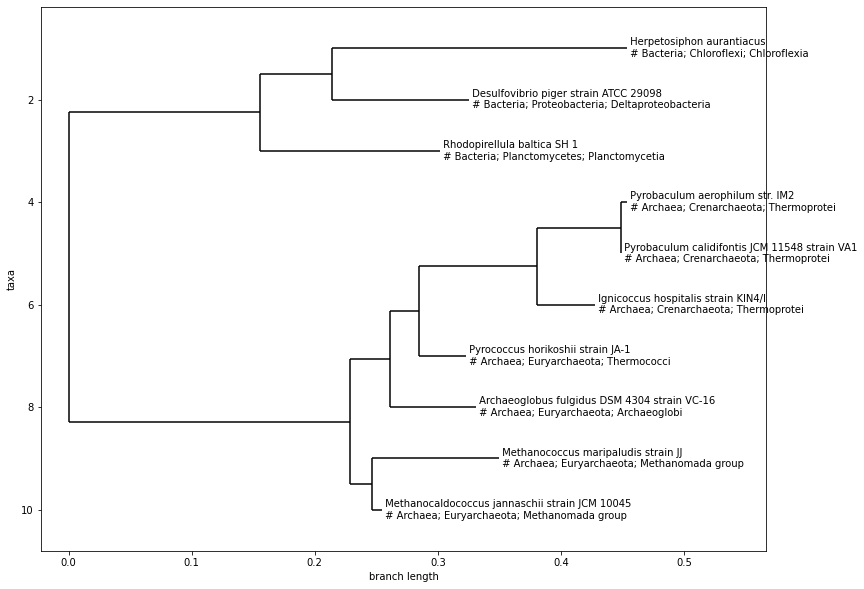

In [8]:
# Функция, возвращающая полные названия и таксоны для узлов
def label_func(node):
    key = str(node)    # получаем айдишник
    if key in full_names:    # если у нас есть для этой штуки полное имя (нужно чтобы пропускать внутренние узлы)
        label = full_names[key]    # получаем полное имя
        short_label = re.match(r'.+? (.+?) 16S', label).groups()[0]    
        # re.match проверяет строку на соответтвие регулярному выражению и извлекает подходящий участок
        # извлекаем из полного имени все самое нужное
        taxa3 = re.match(r'(.+?;.+?;.+?);', taxonomy[key]).groups()[0]    # извлекаем таксон
        return f'{short_label}\n # {taxa3}'    # возвращаем имя и таксон
    return ''    # внутренние узлы не именуем


# Считываем полученное дерево
tree = Phylo.read(ML_TREE_NAME, 'newick')

# Укореняем
tree.root_at_midpoint()

# Строим полученное дерево
fig, ax = plt.subplots(figsize=(13,10))
Phylo.draw(tree,
           label_func=label_func,    # функция, возвращающая названия узлов
           branch_labels=lambda x: '',    # ветви не подписываем
           axes=ax,
          )

Клады полученного дерева объединяют родственные таксоны и разделяют далекие организмы. Это то, чего мы и ожидали от хорошего дерева!